In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="lime")

## Latex table of results

In [2]:
results = pd.read_csv('results.csv')

In [3]:
patients = ['001', '002', '004', '006', '007', '008']
approaches = ['gpt4o', 'gpt4', 'llava', 'nollm']
prediction_horizons = [3, 6, 9, 12]

In [4]:
results_aggregated = pd.DataFrame()
for approach in approaches:
    for prediction_horizon in prediction_horizons:
        mean_rmse = round(np.mean(results.loc[(results['Approach'] == approach) & (results['Prediction Horizon'] == prediction_horizon), 'RMSE'].values), 2)
        std_rmse = round(np.std(results.loc[(results['Approach'] == approach) & (results['Prediction Horizon'] == prediction_horizon), 'RMSE'].values), 2)
        mean_entry = pd.DataFrame({
            'Approach': [approach],
            'Prediction Horizon': [prediction_horizon],
            'Patient': ['Mean'],
            'RMSE': [mean_rmse]
        })
        std_entry = pd.DataFrame({
            'Approach': [approach],
            'Prediction Horizon': [prediction_horizon],
            'Patient': ['Std'],
            'RMSE': [std_rmse]
        })
        results_aggregated = pd.concat([results_aggregated, mean_entry, std_entry])

In [5]:
def create_latex_table(df):
    horizons = [3, 6, 9, 12]
    horizon_text = ['15 minutes', '30 minutes', '45 minutes', '60 minutes']
    approaches = ['gpt4o', 'gpt4', 'llava', 'nollm']
    table = '\\begin{table}[h]\n\\centering\n\\begin{tabular}{l' + 'c' * len(horizons) + '}\n\\toprule\n'
    table += 'Approach & ' + ' & '.join(map(str, horizon_text)) + ' \\\\\n\\midrule\n'

    for approach in approaches:
        row = approach
        for horizon in horizons:
            mean_value = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == horizon) & (df['Patient'] == 'Mean')]['RMSE'].values[0]
            std_value = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == horizon) & (df['Patient'] == 'Std')]['RMSE'].values[0]
            row += f' & {mean_value:.2f} ± {std_value:.2f}'
        row += ' \\\\\n'
        table += row

    table += '\\bottomrule\n\\end{tabular}\n\\caption{Mean RMSE over all six selected patients for different approaches and prediction horizons.}\n\\end{table}'
    return table


latex_table = create_latex_table(results_aggregated)
print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{lcccc}
\toprule
Approach & 15 minutes & 30 minutes & 45 minutes & 60 minutes \\
\midrule
gpt4o & 10.98 ± 3.69 & 22.31 ± 7.35 & 33.82 ± 10.98 & 43.70 ± 15.10 \\
gpt4 & 10.73 ± 3.68 & 22.37 ± 7.26 & 33.71 ± 10.94 & 43.34 ± 14.74 \\
llava & 10.69 ± 3.40 & 22.15 ± 7.23 & 33.43 ± 10.69 & 44.20 ± 14.45 \\
nollm & 11.18 ± 3.78 & 23.03 ± 7.35 & 33.97 ± 11.80 & 44.13 ± 16.45 \\
\bottomrule
\end{tabular}
\caption{Mean RMSE over all six selected patients for different approaches and prediction horizons.}
\end{table}


## Plot predictions

In [6]:
def plot_timeline_with_predictions(y_tests, y_preds):
    data_ground_truth = pd.DataFrame({
        'Datetime': np.arange(len(y_tests)),
        'Glucose Level': y_tests,
        'Type': 'Ground Truth'
    })
    data_predictions = pd.DataFrame({
        'Datetime': np.arange(len(y_preds)),
        'Glucose Level': y_preds,
        'Type': 'Prediction'
    })
    data_combined = pd.concat([data_ground_truth, data_predictions], ignore_index=True)
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'], 
             x='Datetime', 
             y='Glucose Level', 
             label='Ground Truth', 
             color='#1f77b4')
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Prediction'], 
                x='Datetime', 
                y='Glucose Level', 
                label='Prediction', 
                color='#ff7f0e',  
                alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Glucose Level (mg/dL)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

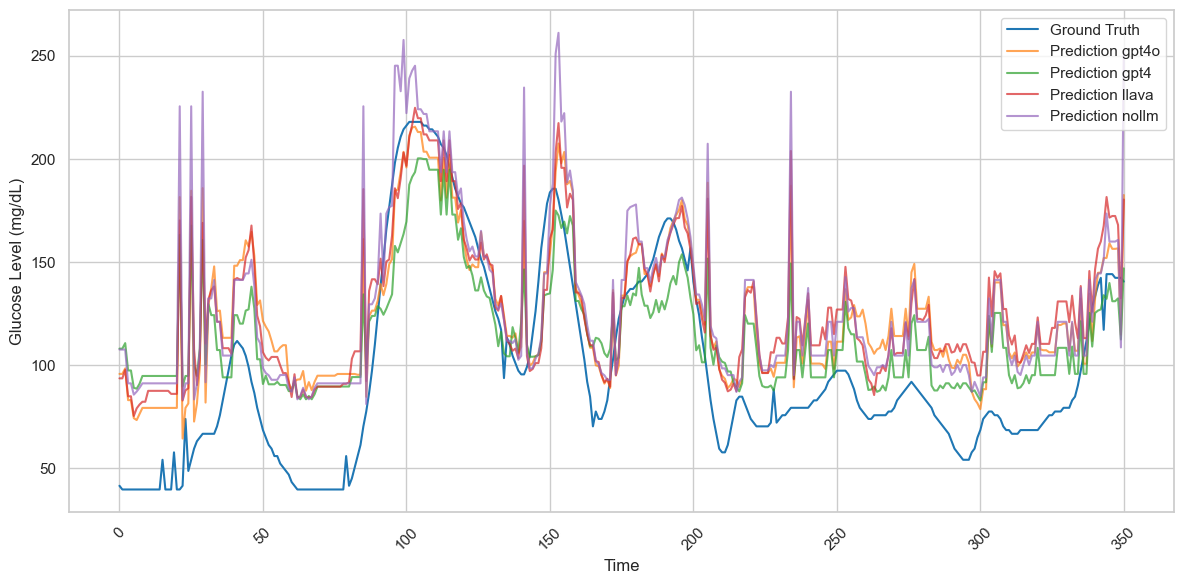

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

approaches = ['gpt4o', 'gpt4', 'llava', 'nollm']

def plot_timeline_with_predictions(y_tests, y_preds, approaches):
    data_ground_truth = pd.DataFrame({
        'Datetime': np.arange(len(y_tests)),
        'Glucose Level': y_tests,
        'Type': 'Ground Truth'
    })
    
    all_data_predictions = []
    for approach in approaches:
        data_predictions = pd.DataFrame({
            'Datetime': np.arange(len(y_preds[approach])),
            'Glucose Level': y_preds[approach],
            'Type': f'Prediction {approach}'
        })
        all_data_predictions.append(data_predictions)
    
    data_combined = pd.concat([data_ground_truth] + all_data_predictions, ignore_index=True)
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'], 
                 x='Datetime', 
                 y='Glucose Level', 
                 label='Ground Truth', 
                 color='#1f77b4',
                 alpha=1.0)
    
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i, approach in enumerate(approaches):
        sns.lineplot(data=data_combined[data_combined['Type'] == f'Prediction {approach}'], 
                     x='Datetime', 
                     y='Glucose Level', 
                     label=f'Prediction {approach}', 
                     color=colors[i],
                     alpha=0.7)
    
    plt.xlabel("Time")
    plt.ylabel("Glucose Level (mg/dL)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

ph = 6
patient = '008'
y_tests = None
y_preds = {}

for approach in approaches:
    patients_glucose_data = pd.read_csv(f'data/{approach}/{ph}/patients_glucose_data_{patient}.csv')
    
    test_patient_data = patients_glucose_data[patients_glucose_data['patient'] == int(patient[2])]
    test = test_patient_data.iloc[int(len(test_patient_data) * 0.7):]
    X_test, y_test = test.drop(['glucose_next', 'datetime', 'patient'], axis=1), test['glucose_next']
    model_path = f"models/{approach}/lightgbm_model_{patient}.joblib"
    model = joblib.load(model_path)
    y_pred = model.predict(X_test)
    
    if y_tests is None:
        y_tests = y_test
    
    y_preds[approach] = y_pred

plot_timeline_with_predictions(y_tests, y_preds, approaches)


## Plot macronutrients

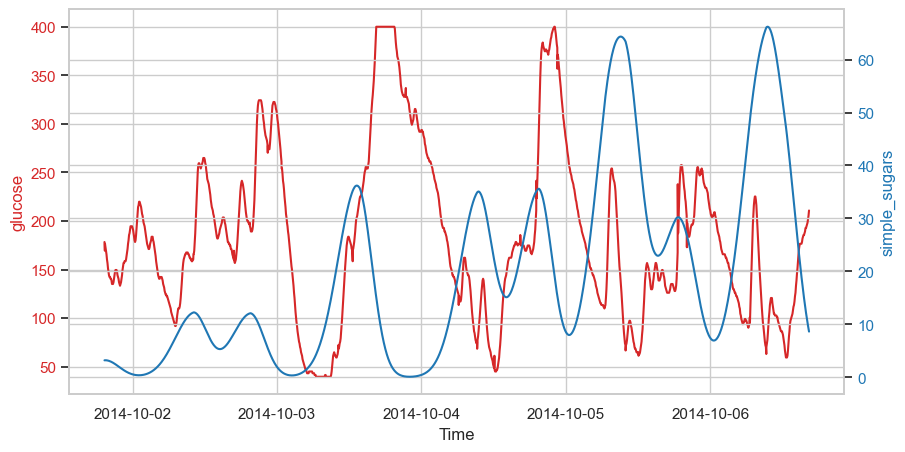

In [11]:
patients = ['001', '002', '004', '006', '007', '008']

def plot_feature_vs_glucose(df, feature_name, datetime_col='datetime'):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('glucose', color=color)
    ax1.plot(df[datetime_col], df['glucose'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(feature_name, color=color)  
    ax2.plot(df[datetime_col], df[feature_name], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.grid(True)
    plt.show()

patient = '001'
approach = 'gpt4o'
ph = 6
patients_glucose_data = pd.read_csv(f'data/{approach}/{ph}/patients_glucose_data_{patient}.csv')
test_patient_data = patients_glucose_data[patients_glucose_data['patient'] == int(patient[2])]
plot_feature_vs_glucose(test_patient_data.copy(), 'simple_sugars')

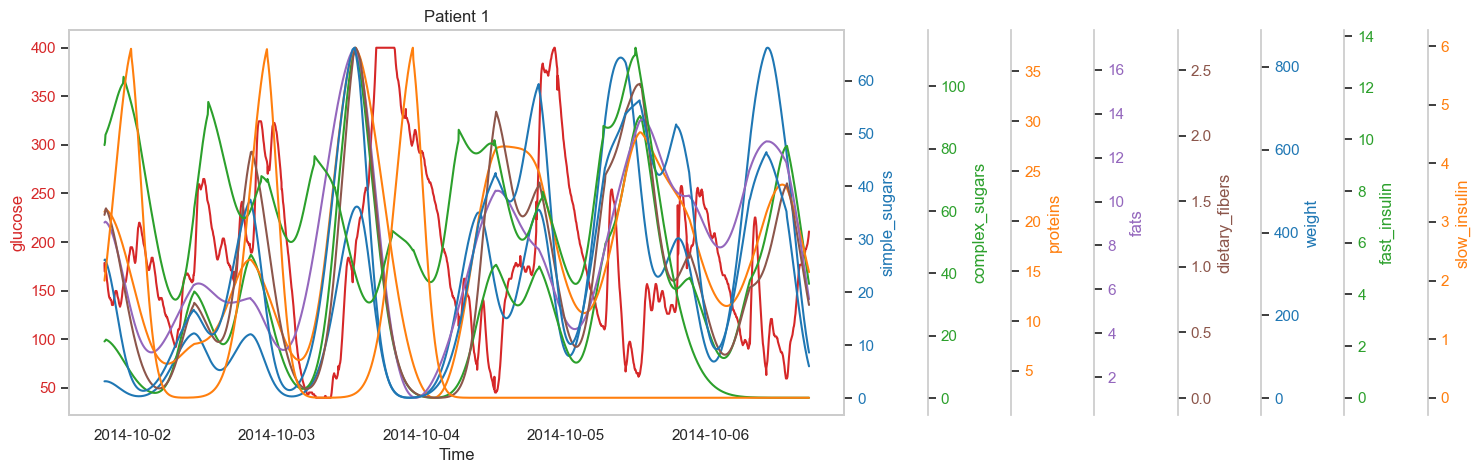

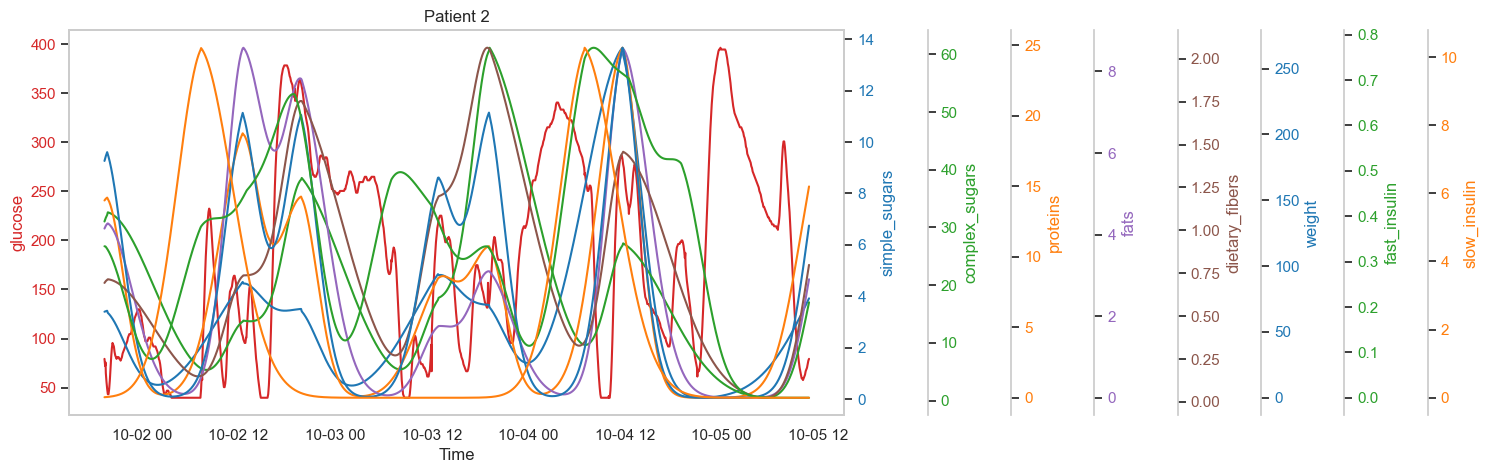

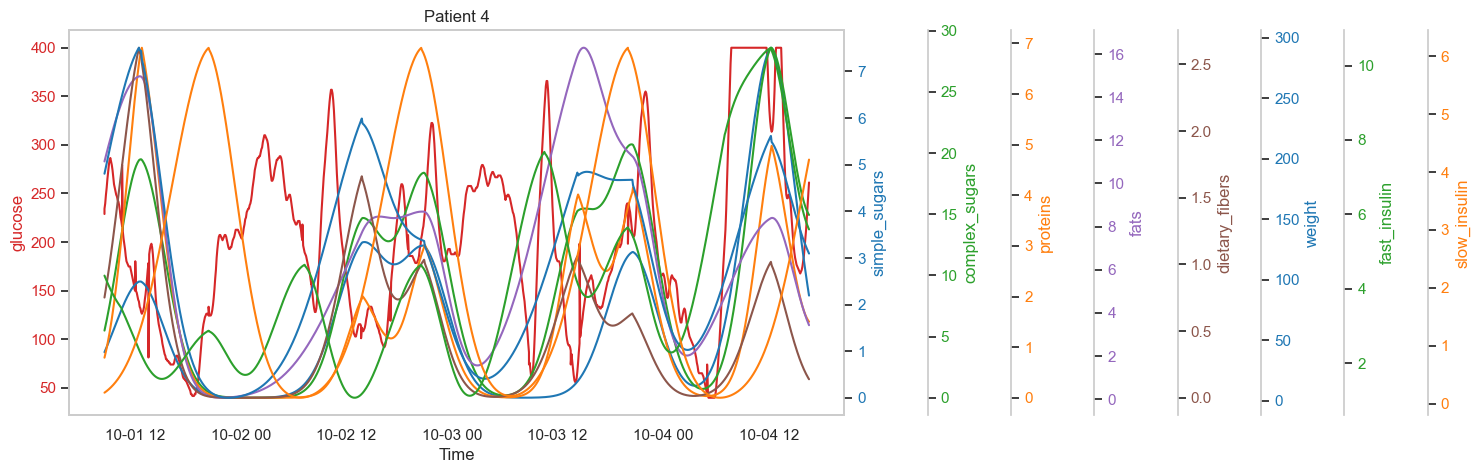

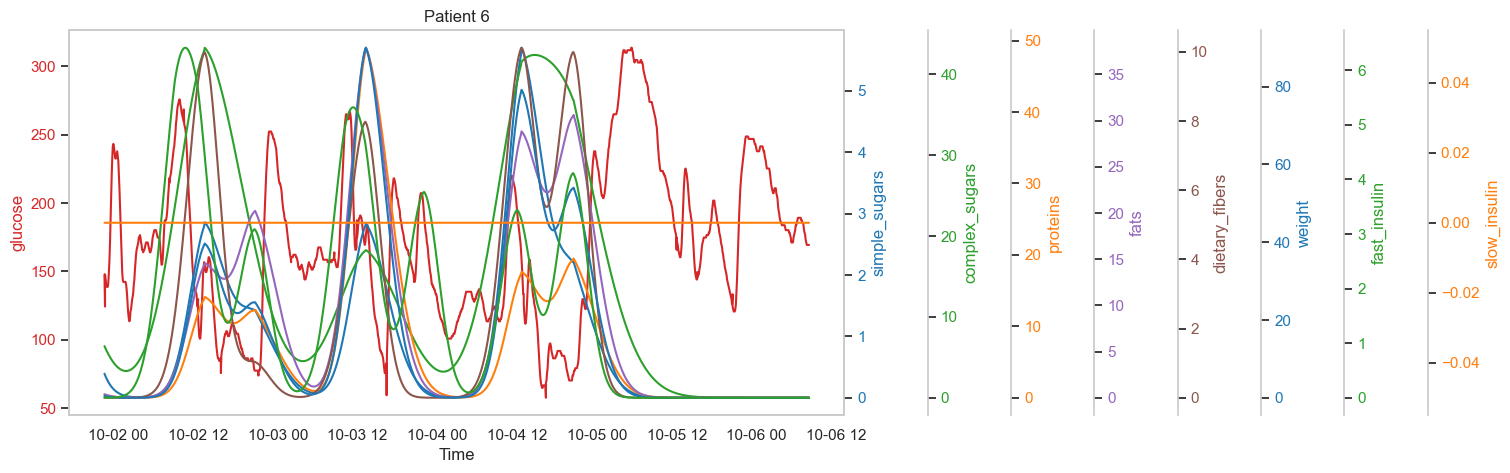

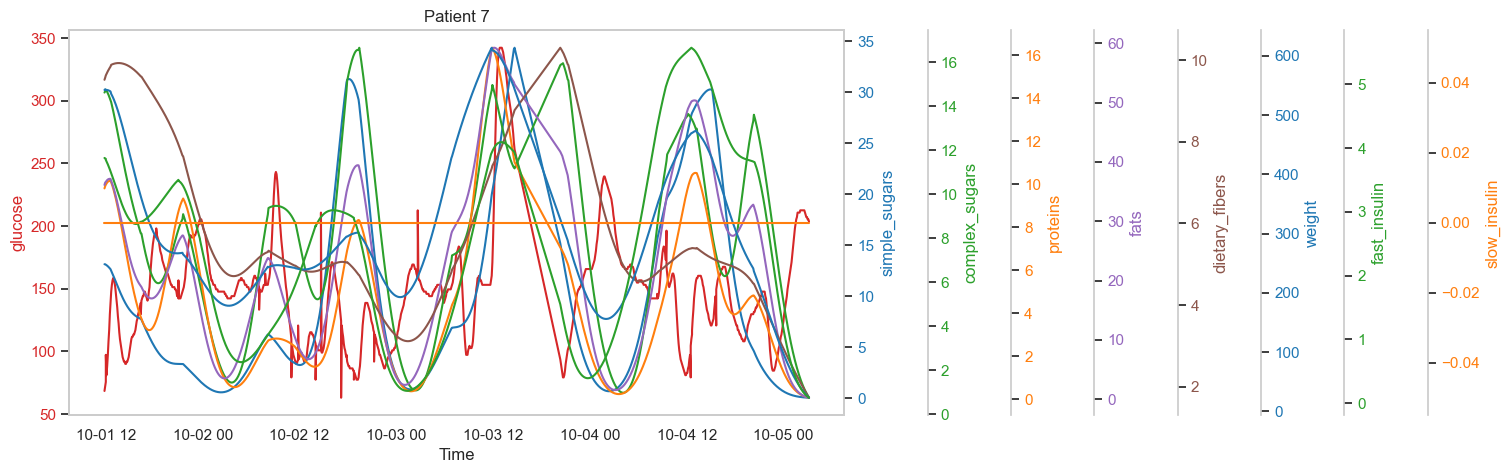

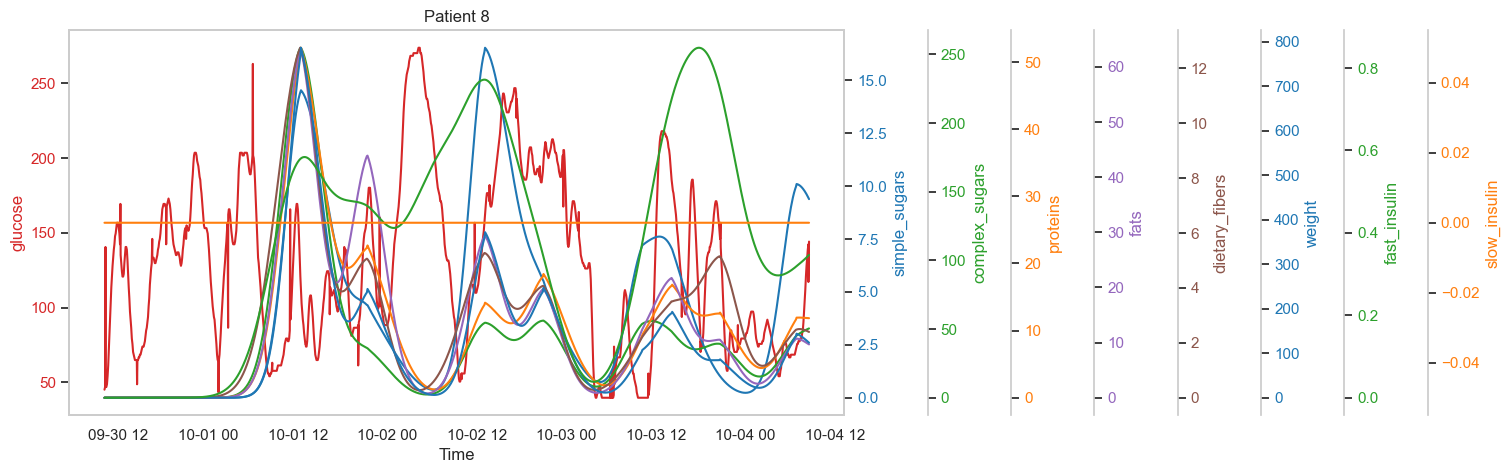

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_features_vs_glucose(df, feature_names, datetime_col='datetime'):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('glucose', color=color)
    ax1.plot(df[datetime_col], df['glucose'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(False)  # Turn off grid for ax1
    
    ax_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown']
    for i, feature_name in enumerate(feature_names):
        ax = ax1.twinx()
        ax.spines['right'].set_position(('outward', 60 * i))
        color = ax_colors[i % len(ax_colors)]
        ax.set_ylabel(feature_name, color=color)
        ax.plot(df[datetime_col], df[feature_name], color=color)
        ax.tick_params(axis='y', labelcolor=color)
        ax.grid(False)  # Turn off grid for ax2

    plt.title(f'Patient {df["patient"].iloc[0]}')
    plt.show()

patients = ['001', '002', '004', '006', '007', '008']
approach = 'gpt4o'
ph = 6
features = ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers', 'weight', 'fast_insulin', 'slow_insulin']

for patient in patients:
    patients_glucose_data = pd.read_csv(f'data/{approach}/{ph}/patients_glucose_data_{patient}.csv')
    test_patient_data = patients_glucose_data[patients_glucose_data['patient'] == int(patient)]
    plot_features_vs_glucose(test_patient_data.copy(), features)


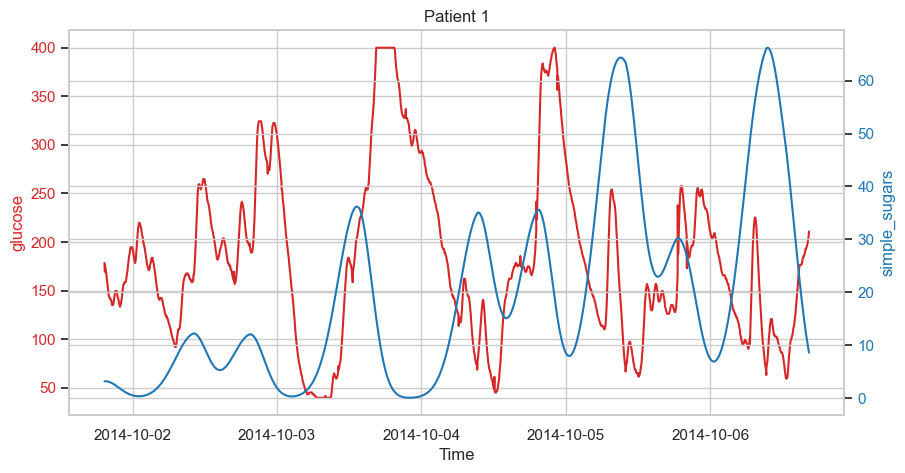

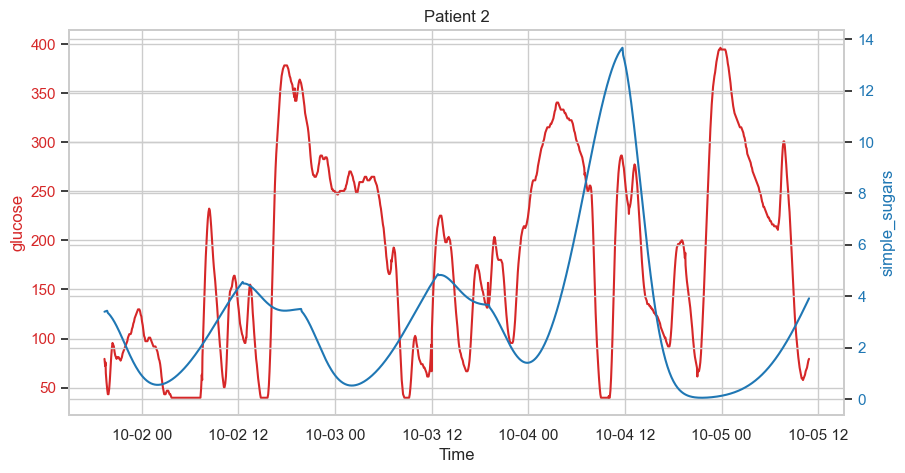

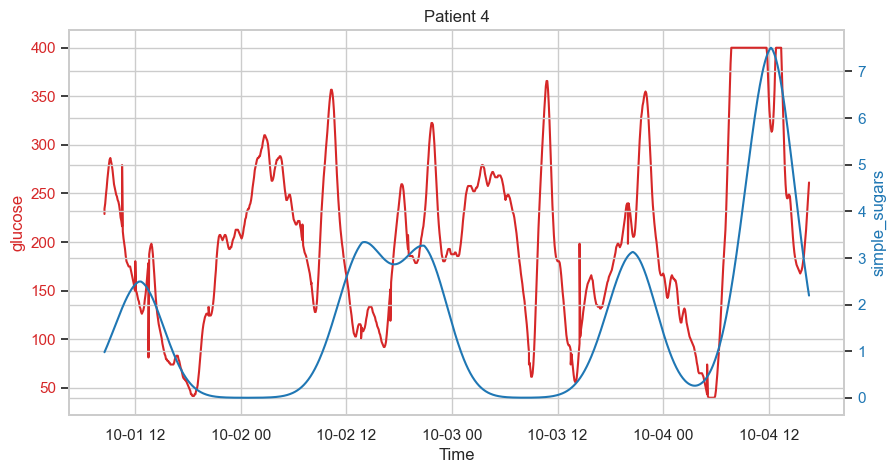

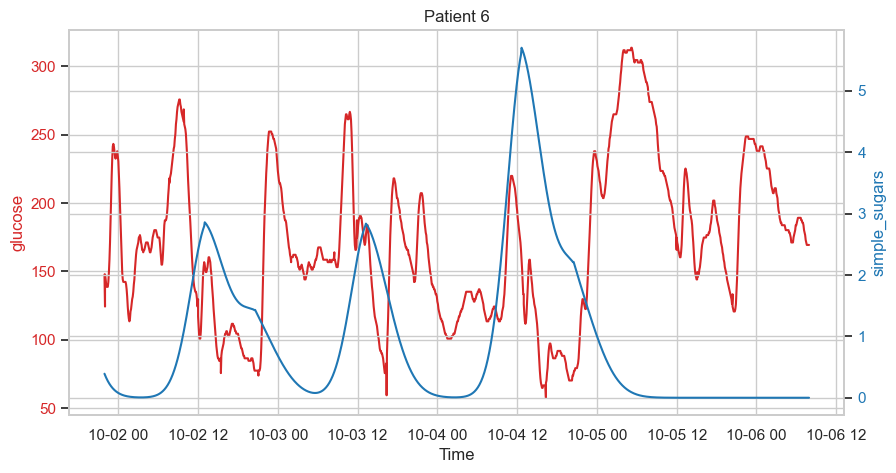

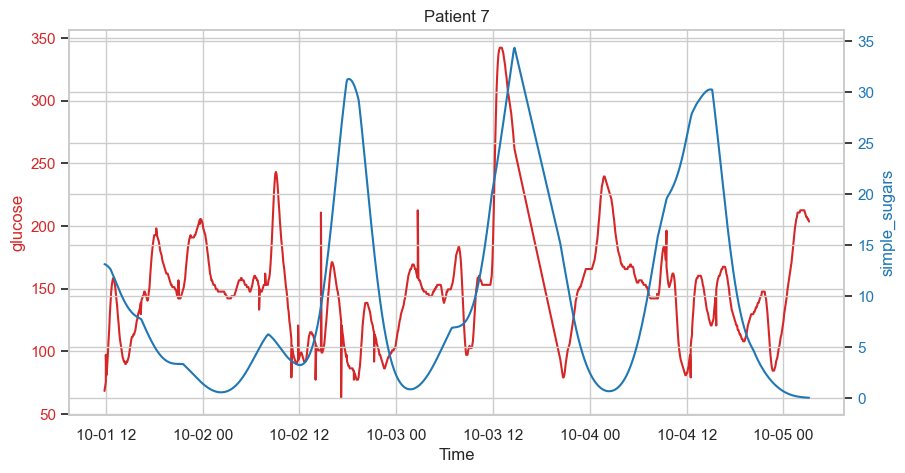

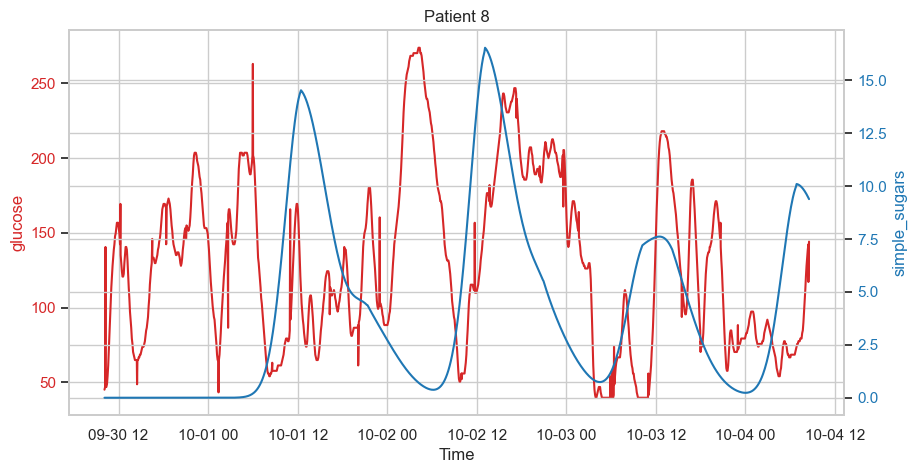

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_vs_glucose(df, feature_name, datetime_col='datetime'):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('glucose', color=color)
    ax1.plot(df[datetime_col], df['glucose'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(feature_name, color=color)  
    ax2.plot(df[datetime_col], df[feature_name], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.grid(True)
    plt.title(f'Patient {df["patient"].iloc[0]}')
    plt.show()

patients = ['001', '002', '004', '006', '007', '008']
approach = 'gpt4o'
ph = 6

for patient in patients:
    patients_glucose_data = pd.read_csv(f'data/{approach}/{ph}/patients_glucose_data_{patient}.csv')
    test_patient_data = patients_glucose_data[patients_glucose_data['patient'] == int(patient)]
    plot_feature_vs_glucose(test_patient_data.copy(), 'simple_sugars')


## Plot feature importances

In [350]:
def plot_feature_importances(model, columns):
    importances_df = pd.DataFrame({
        'Features': columns,
        'Importances': model.feature_importances_
    })
    importances_df = importances_df.sort_values(by='Importances', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Features'], importances_df['Importances'], color='skyblue')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  
    plt.show()

In [351]:
patients_glucose_data

,glucose,datetime,glucose_next,glucose_change_5,simple_sugars,complex_sugars,proteins,fats,dietary_fibers,weight,fast_insulin,slow_insulin,patient
0,178.38018,2014-10-01 19:19:00,160.36198,-7.20728,2.485676,7.748299,5.836937,11.656173,2.004607,205.238742,13.480457,4.545403,1
1,169.37108,2014-10-01 19:23:00,156.75834,-9.00910,2.492704,7.775845,5.912208,11.668344,2.020203,205.831278,13.524130,4.614552,1
2,176.57836,2014-10-01 19:24:00,151.35288,7.20728,2.494286,7.781998,5.930451,11.671123,2.023972,205.974641,13.534820,4.631854,1
3,172.97472,2014-10-01 19:29:00,147.74924,-3.60364,2.501135,7.807881,6.027304,11.683301,2.013032,204.715317,13.557009,4.718434,1
4,169.37108,2014-10-01 19:34:00,144.14560,-3.60364,2.500883,7.814009,6.154283,11.688801,1.983059,201.162009,13.573833,4.805090,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6930,133.33468,2014-10-04 08:16:56,144.14560,5.40546,8.750789,19.015004,2.758517,9.406655,0.782192,188.662549,5.991955,0.000000,8
6931,138.74014,2014-10-04 08:21:56,142.34378,5.40546,8.636311,19.068423,2.732535,9.462604,0.773825,188.151257,6.009096,0.000000,8
6932,142.34378,2014-10-04 08:26:56,142.34378,3.60364,8.517671,19.118823,2.707023,9.518011,0.765575,187.633512,6.026874,0.000000,8
6933,117.11830,2014-10-04 08:27:00,142.34378,-25.22548,8.516063,19.119476,2.706686,9.518747,0.765466,187.626581,6.027115,0.000000,8


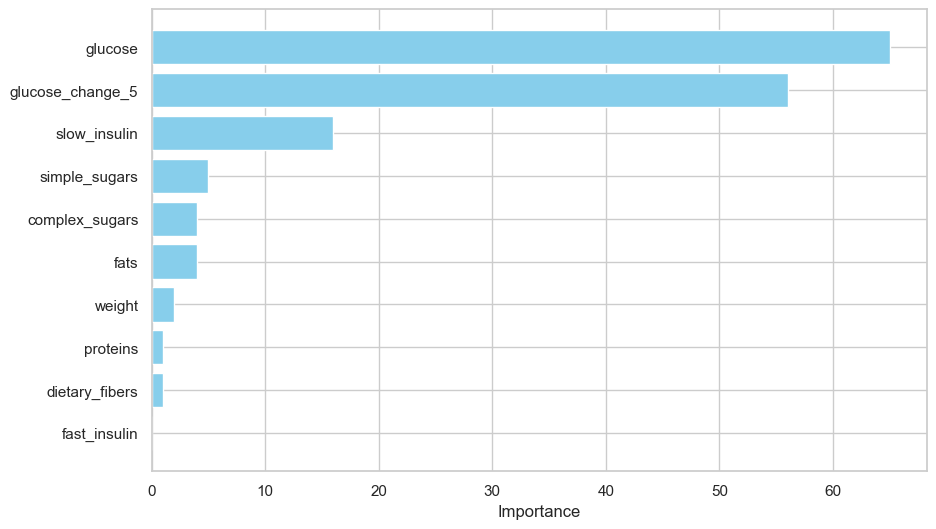

In [355]:
features = ['glucose', 'glucose_change_5',	'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers', 'weight', 'fast_insulin', 'slow_insulin']
patients = ['001', '002', '004', '006', '007', '008']
test_patient = '007'  
model_path = f"models/gpt4o/lightgbm_model_{test_patient}.joblib"

# Load the model
model = joblib.load(model_path)

def plot_feature_importances(model, columns):
    importances_df = pd.DataFrame({
        'Features': columns,
        'Importances': model.feature_importances_
    })
    importances_df = importances_df.sort_values(by='Importances', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Features'], importances_df['Importances'], color='skyblue')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  
    plt.show()

plot_feature_importances(model, features)

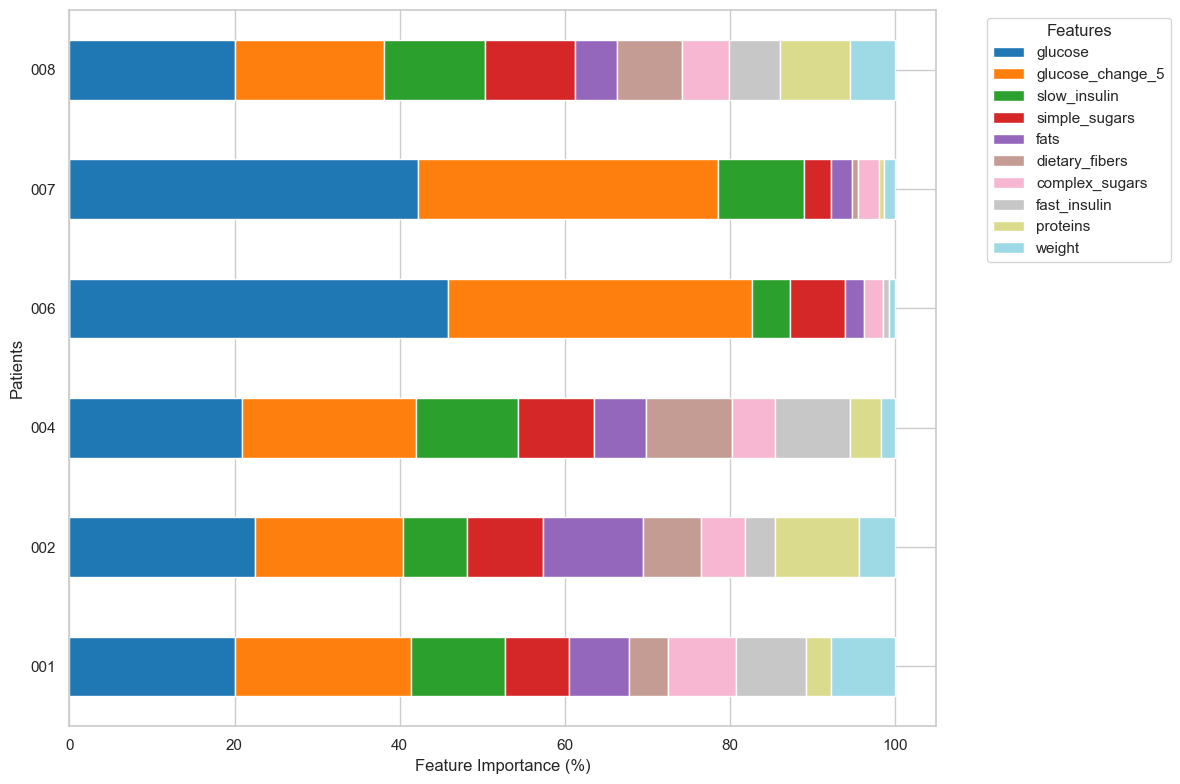

In [357]:
importances_df = pd.DataFrame(index=features)

# Load each patient's model and extract feature importances
for patient in patients:
    model_path = f"models/gpt4o/lightgbm_model_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Calculate total importance for each feature
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100

# Calculate total importance for each feature across all patients
importances_df['Total'] = importances_df.sum(axis=1)

# Sort features by total importance
importances_df = importances_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plotting
importances_df.T.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='tab20')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Patients')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [358]:
importances_df

,001,002,004,006,007,008
glucose,20.038536,22.509960,20.869565,45.864662,42.207792,20.000000
glucose_change_5,21.387283,17.928287,21.086957,36.842105,36.363636,18.103448
slow_insulin,11.368015,7.768924,12.391304,4.511278,10.389610,12.241379
simple_sugars,7.707129,9.163347,9.130435,6.766917,3.246753,10.862069
fats,7.321773,12.151394,6.304348,2.255639,2.597403,5.172414
dietary_fibers,4.624277,6.972112,10.434783,0.000000,0.649351,7.758621
complex_sugars,8.285164,5.378486,5.217391,2.255639,2.597403,5.689655
fast_insulin,8.477842,3.585657,9.130435,0.751880,0.000000,6.206897
proteins,3.082852,10.159363,3.695652,0.000000,0.649351,8.448276
weight,7.707129,4.382470,1.739130,0.751880,1.298701,5.517241


## Plot local feature importances

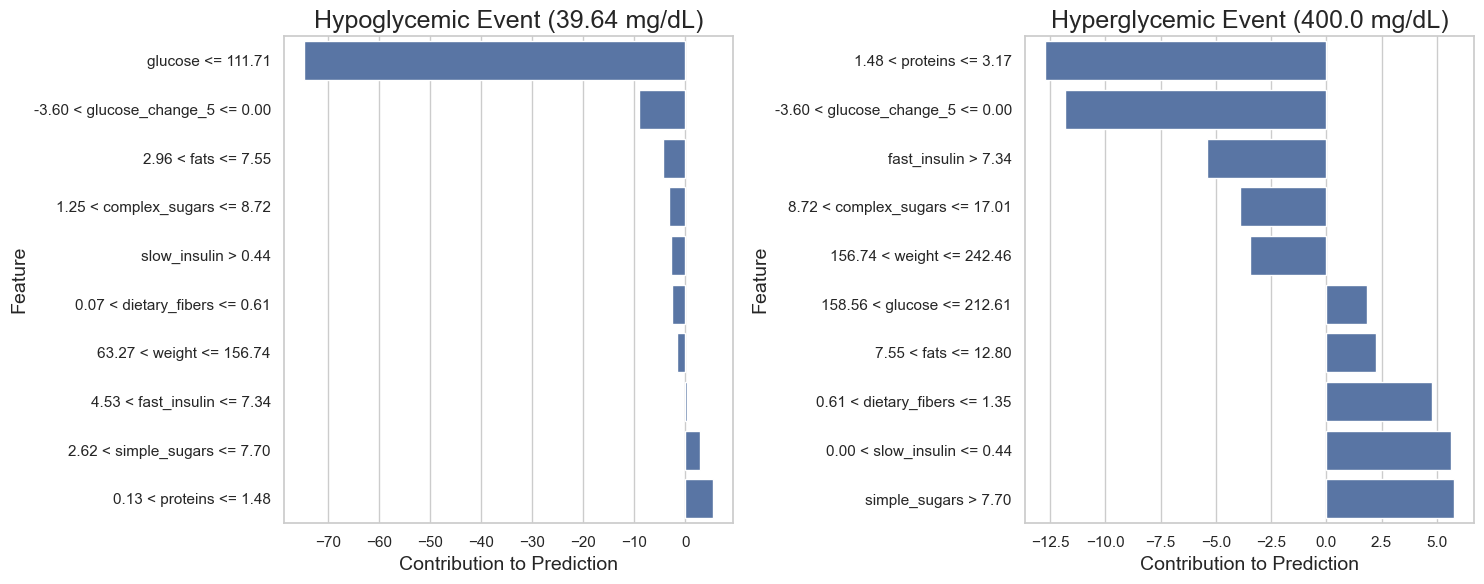

In [377]:


def plot_local_feature_importances(features, hypo_index, hyper_index, y_test):
    X = patients_glucose_data.drop(['glucose_next', 'datetime', 'patient'], axis=1)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X.values,
        feature_names=features,
        class_names=['glucose_next'],
        mode='regression'
    )

    hypo_exp = explainer.explain_instance(
        data_row=X.iloc[hypo_index],
        predict_fn=model.predict,
        num_features=len(features)
    )

    hyper_exp = explainer.explain_instance(
        data_row=X.iloc[hyper_index],
        predict_fn=model.predict,
        num_features=len(features)
    )

    hypo_exp_list = hypo_exp.as_list()
    hyper_exp_list = hyper_exp.as_list()

    hypo_features, hypo_values = zip(*hypo_exp_list)
    hyper_features, hyper_values = zip(*hyper_exp_list)

    hypo_df = pd.DataFrame({
        'Feature': hypo_features,
        'Effect': hypo_values
    }).sort_values(by='Effect', ascending=True)

    hyper_df = pd.DataFrame({
        'Feature': hyper_features,
        'Effect': hyper_values
    }).sort_values(by='Effect', ascending=True)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    sns.barplot(x='Effect', y='Feature', data=hypo_df, ax=axs[0])
    axs[0].set_title(f'Hypoglycemic Event ({round(y_test.values[hypoglycemia_index], 2)} mg/dL)', fontsize=18)
    axs[0].set_xlabel('Contribution to Prediction', fontsize=14)
    axs[0].set_ylabel('Feature', fontsize=14)

    sns.barplot(x='Effect', y='Feature', data=hyper_df, ax=axs[1])
    axs[1].set_title(f'Hyperglycemic Event ({round(y_test.values[hyperglycemia_index], 2)} mg/dL)', fontsize=18)
    axs[1].set_xlabel('Contribution to Prediction', fontsize=14)
    axs[1].set_ylabel('Feature', fontsize=14)

    plt.tight_layout()
    plt.show()

patient = '004'
approach = 'gpt4o'
ph = 6
patients_glucose_data = pd.read_csv(f'data/{approach}/{ph}/patients_glucose_data_{patient}.csv')
test_patient_data = patients_glucose_data[patients_glucose_data['patient'] == int(patient[2])]
test = test_patient_data.iloc[int(len(test_patient_data) * 0.7):]

X_test, y_test = test.drop(['glucose_next', 'datetime', 'patient'], axis=1), test['glucose_next']
hypoglycemia_index = np.argmin(y_test)
hyperglycemia_index = np.argmax(y_test)
plot_local_feature_importances(features, hypoglycemia_index, hyperglycemia_index, y_test)


## LLM thinking

In [390]:
approaches = ['gpt4o', 'gpt4', 'llava']
data_dict = {}

for approach in approaches:
    food_data = pd.read_csv(f'{approach}_food_data/food_data_006.csv')
    message = food_data.loc[1, 'message']
    data_dict[approach] = message

# Parsing the message into individual components
parsed_data = {approach: {} for approach in approaches}

for approach, message in data_dict.items():
    lines = message.split('\n')
    for line in lines:
        if line:
            key, value = line.split(': ', 1)
            parsed_data[approach][key] = value

# Generating LaTeX table
latex_table = r"""
\begin{table}[h]
\centering
\begin{tabular}{lp{3cm}p{3cm}p{3cm}}
\toprule
\textbf{Component} & \textbf{gpt4o} & \textbf{gpt4} & \textbf{llava} \\
\midrule
"""

components = ['Simple sugars (g)', 'Complex sugars (g)', 'Proteins (g)', 'Fats (g)', 'Dietary fibers (g)', 'Weight (g)', 'Explanation']

for component in components:
    row = f"{component} & {parsed_data['gpt4o'].get(component, '')} & {parsed_data['gpt4'].get(component, '')} & {parsed_data['llava'].get(component, '')} \\\\\n"
    latex_table += row

latex_table += r"""
\bottomrule
\end{tabular}
\caption{Food data description for different LLMs}
\end{table}
"""

print(latex_table)



\begin{table}[h]
\centering
\begin{tabular}{lp{3cm}p{3cm}p{3cm}}
\toprule
\textbf{Component} & \textbf{gpt4o} & \textbf{gpt4} & \textbf{llava} \\
\midrule
Simple sugars (g) &  & 35 &  \\
Complex sugars (g) &  & 50 &  \\
Proteins (g) &  & 20 &  \\
Fats (g) &  & 25 &  \\
Dietary fibers (g) &  & 5 &  \\
Weight (g) &  & 600 &  \\
Explanation &  & The meal in the image appears to be a wrapped sandwich, likely to contain meats, vegetables, and possibly sauces, accompanied by a bottled beverage. Given the 1 Swiss Franc coin for scale, the wrap is approximately the length and width of a standard wrap, and the bottle, standard size, is likely to contain roughly 500 ml of liquid. The wrap likely contains complex carbohydrates from the bread, proteins from the meat, some fats, and minimal fibers from the vegetables. The bottled drink is a major source of simple sugars, especially if it's a sweetened beverage. The total meal weight is an estimate based on the visual size comparison with the coin.

In [393]:
food_data = pd.read_csv('gpt4_food_data/food_data_006.csv')
message = food_data.loc[1, 'message']
message

"- Simple sugars (g): 35\n- Complex sugars (g): 50\n- Proteins (g): 20\n- Fats (g): 25\n- Dietary fibers (g): 5\n- Weight (g): 600\n- Explanation: The meal in the image appears to be a wrapped sandwich, likely to contain meats, vegetables, and possibly sauces, accompanied by a bottled beverage. Given the 1 Swiss Franc coin for scale, the wrap is approximately the length and width of a standard wrap, and the bottle, standard size, is likely to contain roughly 500 ml of liquid. The wrap likely contains complex carbohydrates from the bread, proteins from the meat, some fats, and minimal fibers from the vegetables. The bottled drink is a major source of simple sugars, especially if it's a sweetened beverage. The total meal weight is an estimate based on the visual size comparison with the coin."

## LLM meal annotation descriptive statistics

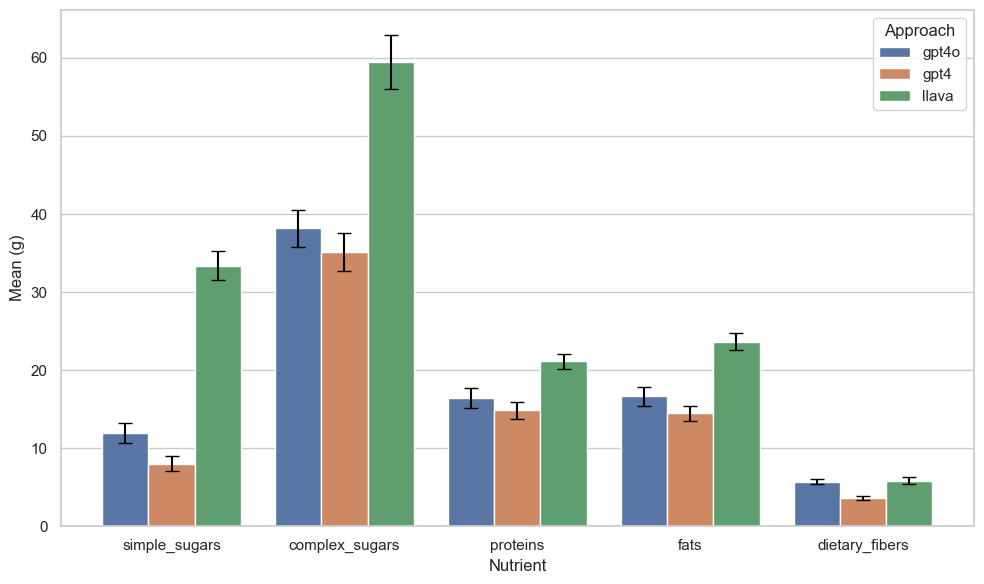

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

approaches = ['gpt4o', 'gpt4', 'llava']
patients = ['001', '002', '004', '006', '007', '008']

data = {approach: [] for approach in approaches}

# Load the data
for approach in approaches:
    for patient in patients:
        food_data = pd.read_csv(f'{approach}_food_data/food_data_{patient}.csv')
        data[approach].append(food_data)

# Compute the mean and standard error for each approach
results = {'Approach': [], 'Nutrient': [], 'Mean': [], 'Std Error': []}
nutrients = ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']

for approach, dfs in data.items():
    combined_df = pd.concat(dfs)
    for nutrient in nutrients:
        mean_value = combined_df[nutrient].mean()
        std_error = combined_df[nutrient].sem()
        results['Approach'].append(approach)
        results['Nutrient'].append(nutrient)
        results['Mean'].append(mean_value)
        results['Std Error'].append(std_error)

results_df = pd.DataFrame(results)

# Plotting the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Nutrient', y='Mean', hue='Approach', data=results_df, errorbar=None, capsize=0.1)

# Add standard error bars
num_approaches = len(approaches)
bar_width = 0.8 / num_approaches  # width of each bar
for i, approach in enumerate(approaches):
    approach_data = results_df[results_df['Approach'] == approach]
    x_positions = np.arange(len(nutrients)) - 0.4 + bar_width/2 + i * bar_width
    plt.errorbar(x=x_positions, y=approach_data['Mean'], yerr=approach_data['Std Error'], fmt='none', c='black', capsize=5)

plt.xlabel('Nutrient')
plt.ylabel('Mean (g)')
plt.legend(title='Approach')
plt.tight_layout()
plt.show()


In [396]:
food_data.head()

,picture,datetime,simple_sugars,complex_sugars,proteins,fats,dietary_fibers,weight,message
0,001.jpg,2014:10:01 12:21:59,20,15,10,30,5,750,Simple sugars (g): 20\nComplex sugars (g): 15...
1,002.jpg,2014:10:01 12:22:06,20,30,5,10,2,750,Simple sugars (g): 20\nComplex sugars (g): 30...
2,003.jpg,2014:10:01 12:22:15,50,100,20,30,10,540,Simple sugars (g): 50\nComplex sugars (g): 10...
3,005.jpg,2014:10:01 12:22:31,60,120,15,20,3,200,Simple sugars (g): 60\nComplex sugars (g): 12...
4,006.jpg,2014:10:01 21:20:45,50,60,20,30,5,1700,Simple sugars (g): 50\nComplex sugars (g): 60...
